In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import scipy
from scipy import fftpack
import matplotlib as mpl
mpl.rc('image', cmap='gray')

from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import util,mask_util,param_util

In [2]:
#code from https://www.astrobetter.com/wiki/tiki-index.php?page=python_radial_profiles
import numpy as np

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

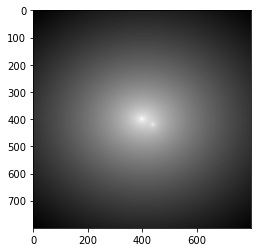

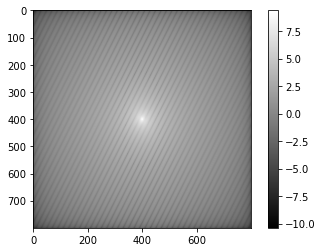

<ipython-input-21-4e7f07574026>:27: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(psd1D))


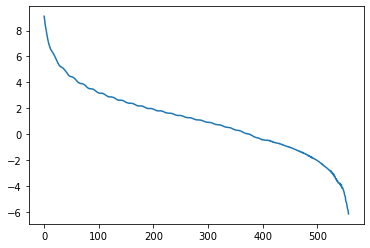

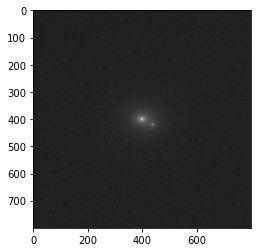

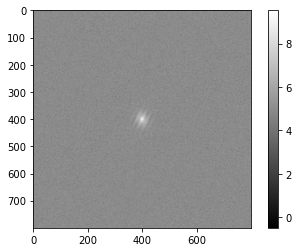

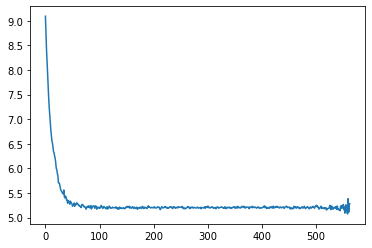

In [21]:
source_model_list=['SERSIC','SERSIC_ELLIPSE']#,'ELLIPSOID','ELLIPSOID']
kwargs_source = [{'amp':0.1, 'R_sersic':64, 'n_sersic':3.0, 'center_x':40., 'center_y':20.},
                {'amp':0.5, 'R_sersic':80, 'n_sersic':2.0,'center_x':0, 'center_y':0,'e1':0.1,'e2':0.}]#,
#                 {'amp':2., 'radius':160, 'center_x':50, 'center_y':20,'e1':0.2,'e2':0.},
#                 {'amp':0.5, 'radius':160, 'center_x':0., 'center_y':-20,'e1':0.1,'e2':0.1}]
Source = LightModel(source_model_list)
x,y=util.make_grid(800,1)
source_image = util.array2image(Source.surface_brightness( x, y, kwargs_source))

plt.imshow(np.log10(source_image))
plt.show()

img = source_image-np.median(source_image)
sersic_pert_image = img
prof_sersic_pert=azimuthalAverage(img,center=np.unravel_index(np.argmax(img),np.shape(img)))

F = fftpack.fftshift( fftpack.fft2(img) )
psd2D = np.abs(F)**2
psd1D = azimuthalAverage(psd2D)
img_doublesersicnoiseless=source_image.copy()
psd1D_doublesersicnoiseless = psd1D.copy()

plt.imshow(np.log10(psd2D))
plt.colorbar()
plt.show()

plt.plot(np.log10(psd1D))
plt.show()


noise=np.random.normal(loc=0., scale=1.0, size=np.shape(source_image))/2
source_image=source_image+noise
img_doublesersicnoise=source_image.copy()
plt.imshow(source_image)
plt.show()

img = source_image
sersic_pert_image = img
prof_sersic_pert=azimuthalAverage(img,center=np.unravel_index(np.argmax(img),np.shape(img)))

F = fftpack.fftshift( fftpack.fft2(img) )
psd2D = np.abs(F)**2
psd1D = azimuthalAverage(psd2D)

psd1D_doublesersicnoise = psd1D.copy()

plt.imshow(np.log10(psd2D))
plt.colorbar()
plt.show()

plt.plot(np.log10(psd1D))
plt.show()

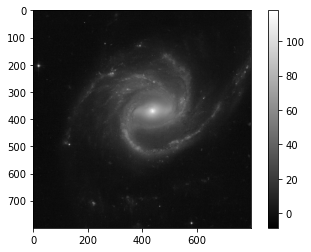

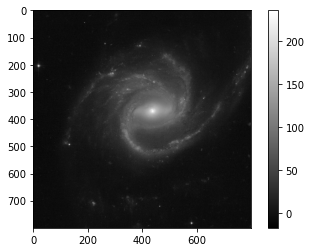

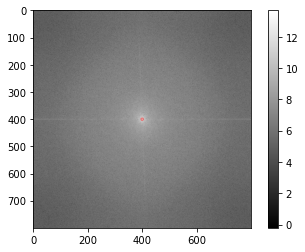

high pass


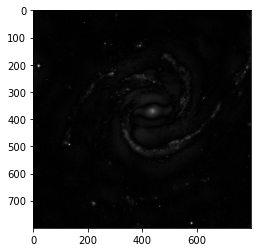

difference


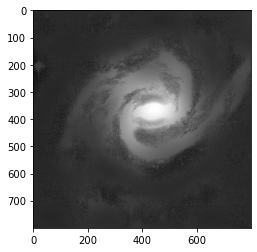

low pass


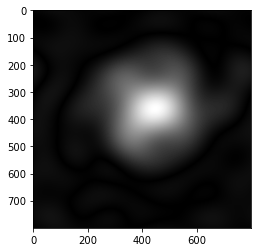

<ipython-input-12-8efdf89405f6>:87: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(psd1D_hi_filtered))
<ipython-input-12-8efdf89405f6>:88: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(psd1D_low_filtered))


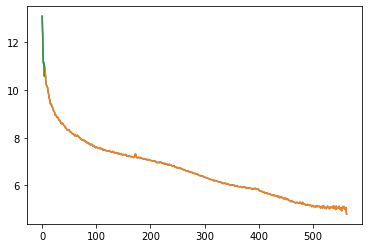

In [12]:

source_image=mpimg.imread('test_power_spectrum/Hubble_Galaxies_dr-60f6.jpeg')
img_tf = source_image[50:850,:800,0]-np.median(source_image[50:850,:800,0])
plt.imshow(img_tf/2)
plt.colorbar()
# print(np.max(img_tf))
plt.show()
F = fftpack.fftshift(fftpack.fft2(img_tf/2.))
psd2D = np.abs(F)**2
psd1D = azimuthalAverage(psd2D)
psd1D_spiralhalf = psd1D.copy()
plt.imshow(img_tf)
plt.colorbar()
# print(np.max(img_tf))
plt.show()
F = fftpack.fftshift(fftpack.fft2(img_tf))
psd2D = np.abs(F)**2
psd1D = azimuthalAverage(psd2D)

img_spiral = img_tf.copy()
psd1D_spiral = psd1D.copy()





plt.imshow(np.log10(psd2D))
plt.colorbar()

f_size=np.shape(F)[0]



filter_rad=5
def high_pass(array,center_x,center_y,filter_rad): #there has to be a faster way to make this array
    x_range=np.arange(0,np.shape(array)[0])
    y_range=np.arange(0,np.shape(array)[1])
    x_grid,y_grid=np.meshgrid(x_range,y_range)
    x_shift = x_grid - center_x
    y_shift = y_grid - center_y
    R = np.sqrt(x_shift*x_shift + y_shift*y_shift)
    mask = np.empty_like(R)
    mask[R > filter_rad] = 1
    mask[R <= filter_rad] = 0
    return mask
def inverse_fft(fft):
    img = fftpack.ifft2(fft)
    if np.all(np.imag(img)<10**-13):
        img=np.abs(img)
    else:
        print('Error: problem with fft: output is complex')
    return img

circ=mpl.patches.Circle((np.shape(psd2D)[0]/2,np.shape(psd2D)[1]/2),filter_rad,color='r',alpha=0.3)
plt.gca().add_patch(circ)
plt.show()
high_pass_filter=high_pass(psd2D,np.shape(psd2D)[0]/2,np.shape(psd2D)[1]/2,filter_rad)
hi_filtered_ft=high_pass_filter*F
psd2D_hi_filtered=np.abs(hi_filtered_ft)**2
psd1D_hi_filtered = azimuthalAverage(psd2D_hi_filtered)
hi_filtered_img = inverse_fft(hi_filtered_ft)


print('high pass')
plt.imshow(hi_filtered_img)
# plt.colorbar()
plt.show()

print('difference')
plt.imshow(img_tf-hi_filtered_img)
plt.show()

low_pass_filter=1-high_pass_filter
low_filtered_ft=low_pass_filter*F
psd2D_low_filtered=np.abs(low_filtered_ft)**2
psd1D_low_filtered = azimuthalAverage(psd2D_low_filtered)
low_filtered_img = inverse_fft(low_filtered_ft)

print('low pass')
plt.imshow(low_filtered_img)
# plt.colorbar()
plt.show()


# plt.colorbar()
plt.show()
plt.plot(np.log10(psd1D_spiral))
plt.plot(np.log10(psd1D_hi_filtered))
plt.plot(np.log10(psd1D_low_filtered))
plt.show()

(800, 800)


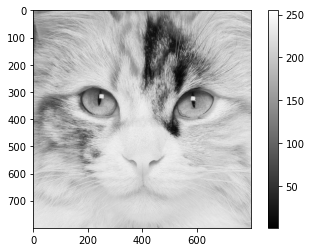

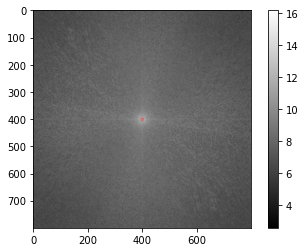

high pass


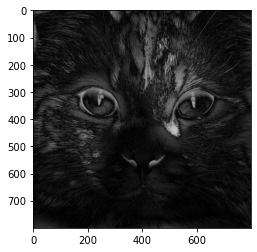

difference


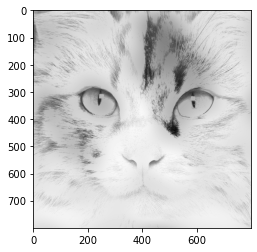

low pass


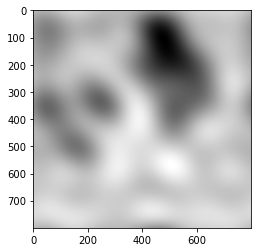

difference


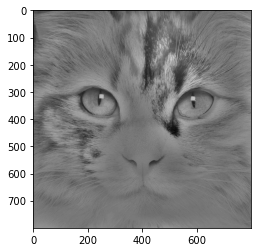

<ipython-input-6-ed3809d5d945>:58: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(psd1D_hi_filtered))
<ipython-input-6-ed3809d5d945>:59: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(psd1D_low_filtered))


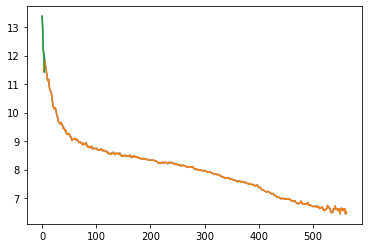

In [6]:

source_image=mpimg.imread('test_power_spectrum/cat_image.jpg')
img_tf = source_image[:,:,0]-np.median(img_tf)
print(np.shape(img_tf))
# img_tf=np.ones_like(img_tf)
plt.imshow(img_tf)
plt.colorbar()
# print(np.max(img_tf))
plt.show()
F = fftpack.fftshift(fftpack.fft2(img_tf))
psd2D = np.abs(F)**2
psd1D = azimuthalAverage(psd2D)

psd1D_cat = psd1D.copy()

plt.imshow(np.log10(psd2D))
plt.colorbar()


f_size=np.shape(F)[0]

circ=mpl.patches.Circle((np.shape(psd2D)[0]/2,np.shape(psd2D)[1]/2),filter_rad,color='r',alpha=0.3)
plt.gca().add_patch(circ)
plt.show()
high_pass_filter=high_pass(psd2D,np.shape(psd2D)[0]/2,np.shape(psd2D)[1]/2,filter_rad)
hi_filtered_ft=high_pass_filter*F
psd2D_hi_filtered=np.abs(hi_filtered_ft)**2
psd1D_hi_filtered = azimuthalAverage(psd2D_hi_filtered)
hi_filtered_img = inverse_fft(hi_filtered_ft)


print('high pass')
plt.imshow(hi_filtered_img)
# plt.colorbar()
plt.show()

print('difference')
plt.imshow(img_tf-hi_filtered_img)
plt.show()

low_pass_filter=1-high_pass_filter
low_filtered_ft=low_pass_filter*F
psd2D_low_filtered=np.abs(low_filtered_ft)**2
psd1D_low_filtered = azimuthalAverage(psd2D_low_filtered)
low_filtered_img = inverse_fft(low_filtered_ft)


print('low pass')
plt.imshow(low_filtered_img)
# plt.colorbar()
plt.show()

print('difference')
plt.imshow(img_tf-low_filtered_img)
# plt.colorbar()
plt.show()
# plt.colorbar()
plt.plot(np.log10(psd1D_cat))
plt.plot(np.log10(psd1D_hi_filtered))
plt.plot(np.log10(psd1D_low_filtered))

# plt.plot(psd1D_cat)
# plt.plot((psd1D_hi_filtered))
# plt.plot((psd1D_low_filtered))
plt.show()

### Goal
Want some way to attach a quantification to the power in higher frequencies ie. complexity of an image. Should be universal to compare across images independent of their average brightness. Added noise (which can increase the amount of power in high frequencies) should be able to be accounted for in this measure somehow.
### Problems to be solved:
1. higher pixel brightness=more power... solved by subtracting median pixel from each image before fft
2. same image with factor of 2 in pixel amplitude gives quadruple power. can be fixed by either:
        i. normalizing the spectrum somehow. These carry problems. Min/max pixel not robust, integrated normalization influenced by noise or lack of noise
        ii. Instead using a comparison of power at different scales (ratio of above vs below band) Problem is that the division is arbitrary. How robust is this to changes in band choice? Noise is also a problem here.

<ipython-input-7-801ed56a7b65>:4: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(psd1d),linestyle='-',color='C'+str(i))


13.431476489593205 13.782647890014474
12.93890222612857 12.778445492067
12.336842234800608 12.17638550073904
8.163731439530938 10.409413111250128
7.747118114729323 8.526926666919689


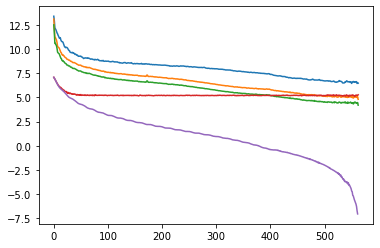

5.405319699045447 5.7564910994667144
6.440543551485465 6.2800868174238955
6.440543551485465 6.2800868174238955
2.9554465608447194 5.20112823256391
6.603251405317399 7.383059957507765


<ipython-input-7-801ed56a7b65>:14: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(psd1dmed),linestyle='-',color='C'+str(i))


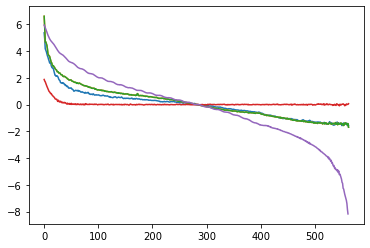

In [7]:
#this cell tries calculating integrated power across the whole spectrum. Normalization is an issue.
i=0
for psd1d in [psd1D_cat,psd1D_spiral,psd1D_spiralhalf,psd1D_doublesersicnoise,psd1D_doublesersicnoiseless]:
    plt.plot(np.log10(psd1d),linestyle='-',color='C'+str(i))
    norm=np.trapz(psd1d,np.arange(len(psd1d)))
    int_freq=np.trapz(psd1d*np.arange(len(psd1d)),np.arange(len(psd1d)))
    print(np.log10(norm),np.log10(int_freq))
    i+=1
plt.show()
#try normalizing at a particular component
i=0
for psd1d in [psd1D_cat,psd1D_spiral,psd1D_spiralhalf,psd1D_doublesersicnoise,psd1D_doublesersicnoiseless]:
    psd1dmed=psd1d/np.median(psd1d)
    plt.plot(np.log10(psd1dmed),linestyle='-',color='C'+str(i))
    norm=np.trapz(psd1dmed,np.arange(len(psd1d)))
    int_freq=np.trapz(psd1dmed*np.arange(len(psd1d)),np.arange(len(psd1d)))
    print(np.log10(norm),np.log10(int_freq))
    i+=1
plt.show()

11.2088232166598
10.16797202384282
9.565912032514857
7.937999701558319
6.128153641771566


<ipython-input-8-144ab2ea42f7>:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(high),linestyle='-',color='C'+str(i))
<ipython-input-8-144ab2ea42f7>:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(low),linestyle=':',color='C'+str(i))
<ipython-input-8-144ab2ea42f7>:25: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(mid),linestyle='-',linewidth=4,color='C'+str(i))
<ipython-input-8-144ab2ea42f7>:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(high),linestyle='-',color='C'+str(i))
<ipython-input-8-144ab2ea42f7>:24: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(low),linestyle=':',color='C'+str(i))
<ipython-input-8-144ab2ea42f7>:25: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(mid),linestyle='-',linewidth=4,color='C'+str(i))
<ipython-input-8-144ab2ea42f7>:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(hig

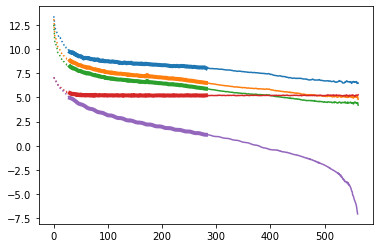

In [8]:
#This tries to calculate fraction of power above or below filter radius
filter_rad=30

def hiband(psd1D):
    result=psd1D.copy()
    result[0:filter_rad]=0
    return result
def lowband(psd1D):
    result=psd1D.copy()
    result[filter_rad:]=0
    return result
def midband(psd1D):
    result=psd1D.copy()
    result[0:filter_rad]=0
    result[round((len(psd1D)/2)):]=0
    return result
i=0

for psd1d in [psd1D_cat,psd1D_spiral,psd1D_spiralhalf,psd1D_doublesersicnoise,psd1D_doublesersicnoiseless]:
    high=hiband(psd1d)
    low=lowband(psd1d)
    mid=midband(psd1d)
    plt.plot(np.log10(high),linestyle='-',color='C'+str(i))
    plt.plot(np.log10(low),linestyle=':',color='C'+str(i))
    plt.plot(np.log10(mid),linestyle='-',linewidth=4,color='C'+str(i))
    hi_norm=np.trapz(high,np.arange(len(high)))#/(len(low)-filter_rad)
    low_norm=np.trapz(low,np.arange(len(low)))#/filter_rad
    print(np.log10(hi_norm))
#     print(np.log10(hi_norm),np.log10(low_norm))
#     print(hi_norm/low_norm)
    mid_norm=np.trapz(mid,np.arange(len(mid)))
#     print(hi_norm/(mid_norm+hi_norm))
    i+=1
plt.show()
# plt.plot(np.log10(hiband(psd1D_spiral)))
# plt.plot(np.log10(hiband(psd1D_spiralhalf)))
# plt.plot(np.log10(hiband(psd1D_doublesersicnoise)))
# plt.plot(np.log10(hiband(psd1D_doublesersicnoiseless)))
# plt.show()


# norm_cat=np.trapz(hiband(psd1D_cat),np.arange(len(psd1D_cat)))
# norm_spiral=np.trapz(hiband(psd1D_spiral),np.arange(len(psd1D_spiral)))
# norm_spiralhalf=np.trapz(hiband(psd1D_spiralhalf),np.arange(len(psd1D_spiral)))
# norm_doublesersicnoise=np.trapz(hiband(psd1D_doublesersicnoise),np.arange(len(psd1D_doublesersicnoise)))
# norm_doublesersicnoiseless=np.trapz(hiband(psd1D_doublesersicnoiseless),np.arange(len(psd1D_doublesersicnoiseless)))

# int_freq_cat=np.trapz(hiband(psd1D_cat)*np.arange(len(psd1D_cat)),np.arange(len(psd1D_cat)))
# int_freq_spiral=np.trapz(hiband(psd1D_spiral)*np.arange(len(psd1D_spiral)),np.arange(len(psd1D_spiral)))

# int_freq_spiral=np.trapz(hiband(psd1D_spiralhalf)*np.arange(len(psd1D_spiral)),np.arange(len(psd1D_spiral)))
# int_freq_doublesersicnoise=np.trapz(hiband(psd1D_doublesersicnoise)*np.arange(len(psd1D_doublesersicnoise)),np.arange(len(psd1D_doublesersicnoise)))
# int_freq_doublesersicnoiseless=np.trapz(hiband(psd1D_doublesersicnoiseless)*np.arange(len(psd1D_doublesersicnoiseless)),np.arange(len(psd1D_doublesersicnoiseless)))

# print(np.log10(norm_cat),np.log10(norm_spiral),np.log10(norm_spiralhalf),np.log10(norm_doublesersicnoise),np.log10(norm_doublesersicnoiseless))
# print(np.log10(int_freq_cat),np.log10(int_freq_spiral),np.log10(int_freq_spiralhalf),np.log10(int_freq_doublesersicnoise),np.log10(int_freq_doublesersicnoiseless))

#compare integrated? normalize somehow?

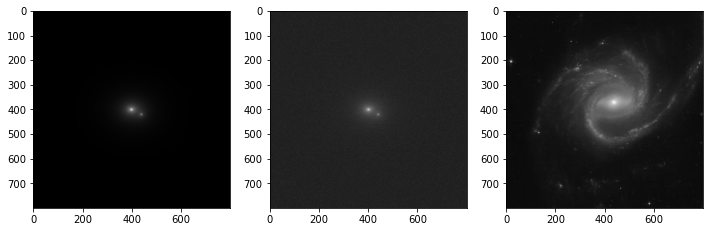

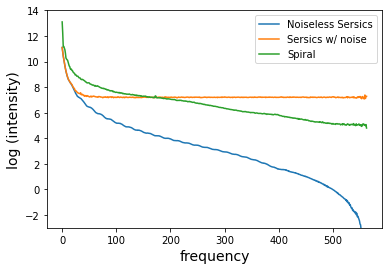

In [56]:
f,ax = plt.subplots(1,3,figsize=(12,5))
ax[0].imshow((img_doublesersicnoiseless*10))
ax[1].imshow((img_doublesersicnoise*10))
ax[2].imshow((img_spiral))
plt.show()
labels=['Noiseless Sersics', 'Sersics w/ noise', 'Spiral']
for i,img in enumerate([img_doublesersicnoiseless*10,img_doublesersicnoise*10,img_spiral]):
    F = fftpack.fftshift(fftpack.fft2(img))
    psd2D = np.abs(F)**2
    psd1D = azimuthalAverage(psd2D)
    plt.plot(np.log10(psd1D+1e-10),linestyle='-',color='C'+str(i),label=labels[i])
plt.ylim([-3,14])
plt.xlabel('frequency',fontsize=14), plt.ylabel('log (intensity)',fontsize=14)
plt.legend()
plt.show()